# Face Recognition

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-6.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a facial recognition system using a pretrained FaceNet model.

[FaceNet](https://arxiv.org/pdf/1503.03832.pdf) is a neural network that encodes the image of a face image into a vector of 128 numbers. By comparing two of these vectors, we can then determine if two pictures are of the same person.

## Download the dataset and model

In [1]:
%%bash

if [ -e "/tmp/keras_facenet.zip" ]; then
    echo "keras_facenet.zip already exists!"
else
    gdown 1pbwUyttn5MWkc4kciW52Xlpf5esUjJUo -O /tmp/
fi

unzip -qn /tmp/keras_facenet.zip -d /tmp

keras_facenet.zip already exists!


## Import libraries

In [2]:
import sys
sys.path.insert(0, '/tmp')
from keras_facenet.inception_resnet_v1 import InceptionResNetV1
from keras import utils
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

2025-01-04 12:28:31.057223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736015311.094356  107956 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736015311.103152  107956 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 12:28:31.131156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize the dataset

This is a small dataset containing photos of some famous celebrities.

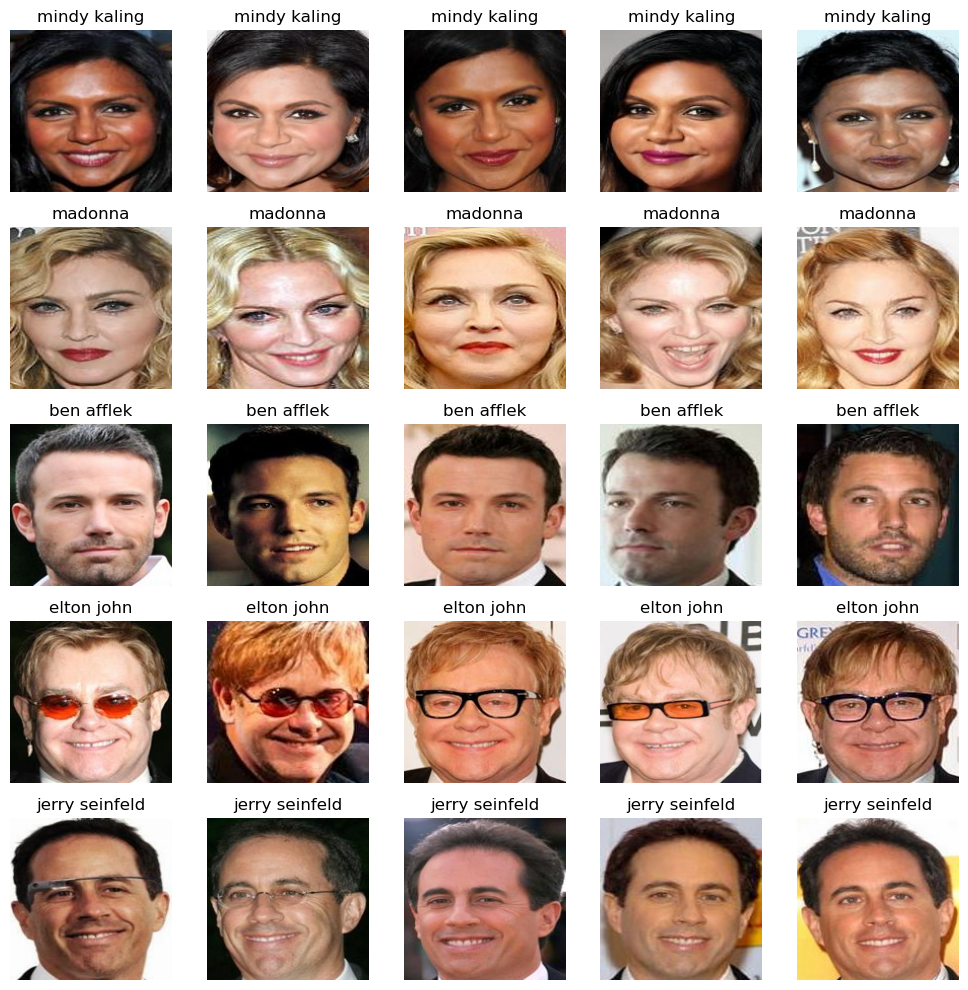

In [3]:
path = "/tmp/keras_facenet/Celebrity_Faces_Dataset"

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, celebrity in enumerate(os.listdir(path)):
    for j, file in enumerate(os.listdir(os.path.join(path, celebrity))):
        image = Image.open(os.path.join(path, celebrity, file)).resize((160, 160))
        axs[i, j].imshow(image)
        axs[i, j].set_title(celebrity.replace("_", " "))
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()

## Load the pretrained FaceNet model

This network follows the [Inception-ResNet V1 architecture](https://arxiv.org/pdf/1409.4842) and uses 160x160 dimensional RGB images as input. The output is a matrix that encodes each input image into a 128-dimensional vector.

In [4]:
model = InceptionResNetV1(weights_path="/tmp/keras_facenet/weights.h5")

I0000 00:00:1736015316.256881  107956 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1683 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Evaluate the model

By calculating the distance between two encodings and setting a threshold, we can determine whether two pictures represent the same person. Therefore, an encoding is good if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different poeple are very different.

In [5]:
def encode_image(image_path, model):
    image = utils.load_img(image_path, target_size=(160, 160))
    image = utils.img_to_array(image) / 255
    image = np.array([image])
    encoding = model.predict_on_batch(image)
    encoding = encoding / np.linalg.norm(encoding, ord=2)
    
    return encoding

def who_is_it(image_path, database, model):
    """
    Implements face recognition by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- Path to an image
        database -- Database containing image encodings along with the name of the person on the image
        model -- Inception model instance in Keras
    
    Returns:
        minimum_distance -- The minimum distance between image_path encoding and the encodings from the database
        identity -- String, the name prediction for the person on image_path
    """

    ## Step 1: Compute the target "encoding" for the image.
    encoding = encode_image(image_path, model)
    
    ## Step 2: Find the closest encoding.
    # Initialize "minimum_distance" to a large value.
    minimum_distance = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, database_encoding) in database.items():
        # Compute L2 distance between the target "encoding" and the current database_encoding from the database.
        distance = np.linalg.norm(encoding - database_encoding)

        # If this distance is less than the minimum_distance, then set minimum_distance to distance, and identity to name.
        if distance < minimum_distance:
            minimum_distance = distance
            identity = name
        
    return minimum_distance, identity

Build a database containing one encoding vector for each celebrity.

In [6]:
path = "/tmp/keras_facenet/Celebrity_Faces_Dataset"
database = {}

for celebrity in os.listdir(path):
    for file in os.listdir(os.path.join(path, celebrity)):
        if file.endswith('1.jpg'):
            database[celebrity] = encode_image(os.path.join(path, celebrity, file), model)

I0000 00:00:1736015325.084634  108079 service.cc:148] XLA service 0x753c44002c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736015325.095151  108079 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-01-04 12:28:45.356016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736015326.888554  108079 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1736015330.587812  108079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


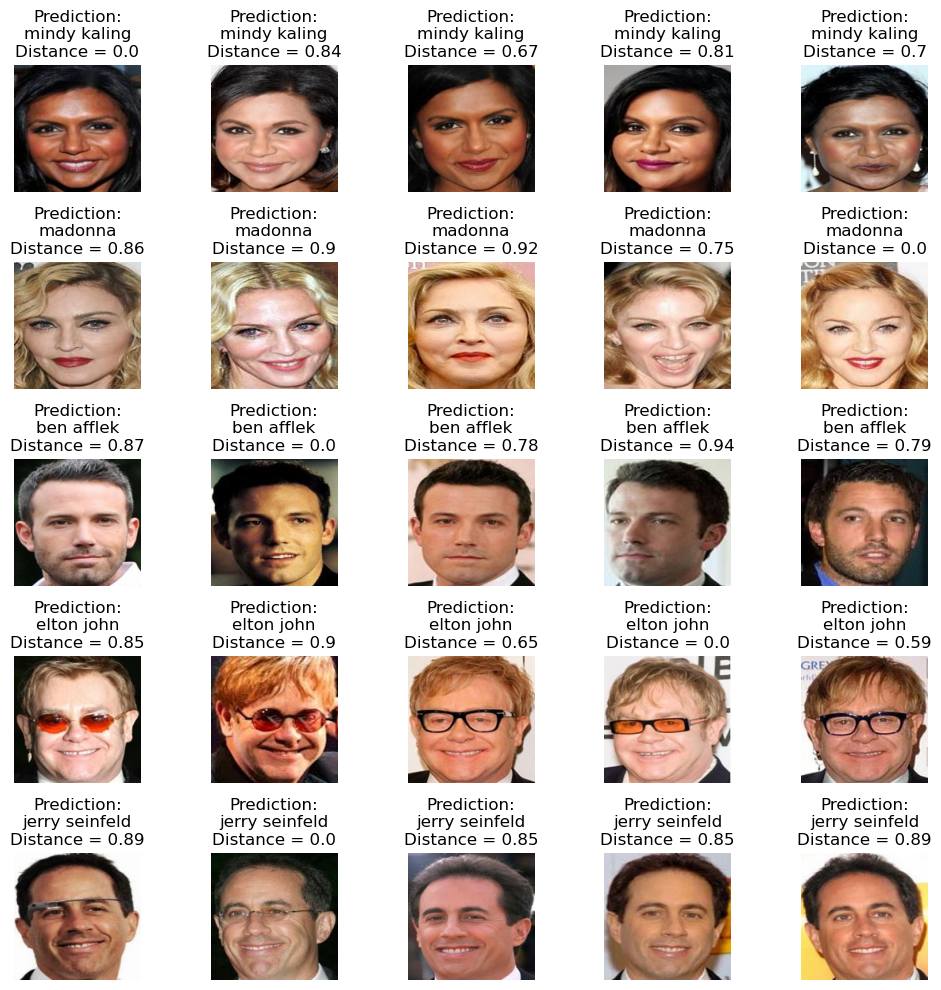

In [7]:
path = "/tmp/keras_facenet/Celebrity_Faces_Dataset"

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, celebrity in enumerate(os.listdir(path)):
    for j, file in enumerate(os.listdir(os.path.join(path, celebrity))):
        image = Image.open(os.path.join(path, celebrity, file)).resize((160, 160))
        minimum_distance, identity = who_is_it(os.path.join(path, celebrity, file), database, model)
        axs[i, j].imshow(image)
        axs[i, j].set_title("Prediction:\n" + identity.replace("_", " ") + "\nDistance = " + str(round(minimum_distance, 2)))
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()